<a href="https://colab.research.google.com/github/tnfru/abstraction_and_reasoning/blob/master/ARC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import sys
if 'google.colab' in sys.modules:
  %tensorflow_version 2.x

  !wget https://raw.githubusercontent.com/tnfru/abstraction_and_reasoning/master/data_utils.py -P utils -nc

  !wget https://raw.githubusercontent.com/tnfru/abstraction_and_reasoning/master/cellular_automata.py -P utils -nc
  sys.path.append('utils')

  from google_drive_downloader import GoogleDriveDownloader as gdd

File ‘utils/data_utils.py’ already there; not retrieving.

File ‘utils/cellular_automata.py’ already there; not retrieving.



In [2]:
import os, json
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Input, Dropout
from tensorflow.keras.activations import softmax
from tensorflow.keras import Sequential

import data_utils
from data_utils import plot_task, plot_prediction, inp2img
import cellular_automata

### Set strategy

In [3]:
gpus = tf.config.experimental.list_logical_devices("GPU")

if len(gpus) > 0:
  strategy = tf.distribute.MirroredStrategy(gpus)
  print('Running on ', len(gpus), ' GPU(s) ')
else:
  strategy = tf.distribute.get_strategy()
  print('Running on CPU')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Running on  1  GPU(s) 


## Read Data

In [4]:
if 'google.colab' in sys.modules:
  gdd.download_file_from_google_drive(file_id='1FUk30rXuym1RygfaDq4g-Uj-CkkG63IE',
                                      dest_path='./data/arc.zip',
                                      unzip=True)
train_tasks, val_tasks, test_tasks = data_utils.get_task_sets()

Unzipping...Done.


In [7]:
print("Number of equal input and output shapes in train:", data_utils.count_equal_dims(train_tasks), "of", len(train_tasks))
print("Number of equal input and output shapes in val:", data_utils.count_equal_dims(val_tasks), "of", len(val_tasks))
print("Number of equal input and output shapes in test:", data_utils.count_equal_dims(test_tasks, isTrain=False), "of", len(test_tasks))

Number of equal input and output shapes in train: 262 of 400
Number of equal input and output shapes in val: 270 of 400
Number of equal input and output shapes in test: 65 of 100


In [8]:
BENCHMARK_TASK_IDS = [1, 347, 26, 32]

# Cellular Automata

For every problem where the input shape is equal to the output shape we can use a Cellular Automata for the transformation.

I want to thank [arseny-n](kaggle.com/arsenynerinovsky/cellular-automata-as-a-language-for-reasoning ) for introducing cellular automata to this problem set.

The CA model I use here is an implementation of [teddykokers PyTorch CA](https://www.kaggle.com/teddykoker/training-cellular-automata-part-i-game-of-life) in tensorflow. I really like the the architecture teddy suggested, so I took the opportunity to practise translating a model from torch to tf.


## Vizualize results

In [9]:
def get_model():
  inputs = Input(shape=(None, None, 10))
  x = Conv2D(128, 3, padding='same')(inputs)
  x = Activation('relu')(x)
  x = Dropout(0.1)(x)
  x = Conv2D(10, 1)(x)
  outputs = softmax(x, axis=3)

  return tf.keras.Model(inputs=inputs, outputs=outputs)

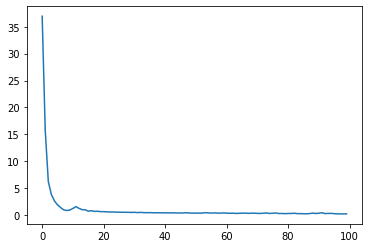

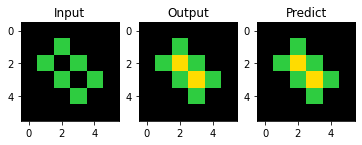

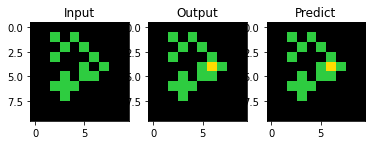

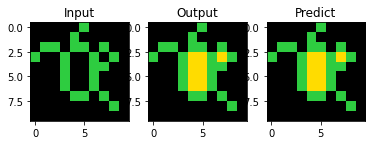

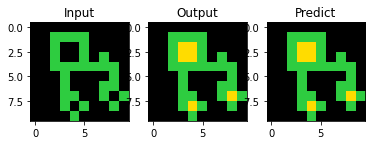

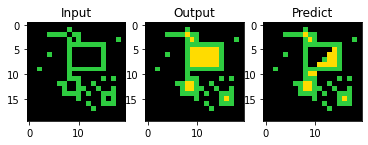

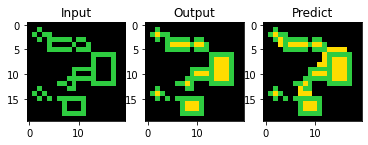

In [10]:
cellular_automata.train_and_plot(train_tasks, [1], model_fn=get_model)